In [1]:
import IPython
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import fftpack
from scipy.ndimage import convolve
from scipy.fftpack import dct, dctn, idctn
from scipy.linalg import circulant
import pywt
from sklearn import linear_model
from IPython.display import clear_output, display
import seaborn as sns

In [2]:
sns.__version__

'0.11.0'

In [3]:
import matplotlib as mpl
mpl.rc('image', cmap='Blues')

In [9]:
width = 128
# img = cv2.imread('./spine_mra.jpg',0)
img = cv2.imread('./SheppLogan_Phantom.png',0, )
img = cv2.resize(img, dsize=(width,width))
# img = cv2.imread('/Users/hamid/Projects/DoE/skull_base.png',0)
# img = cv2.imread('/Users/hamid/Projects/DoE/stem.png',0)
# img = cv2.imread('/Users/hamid/Projects/DoE/spine.png',0)
# img = cv2.imread('/Users/hamid/Projects/DoE/lumbar_spine.png',0)
# img = cv2.imread('/Users/hamid/Projects/DoE/spine_mra.jpg',0)
N = np.prod(img.shape)

In [35]:
def sparsity(img):
    return (np.sum(np.abs(img) > 1e-9) / np.prod(img.shape))

In [46]:
def print_progress(n, i):
    
    if i % np.max([(n // 100), 1]) == 0:
        clear_output(wait=True)
        print((i + 1) * 100 // n, "% done")

0.06317138671875


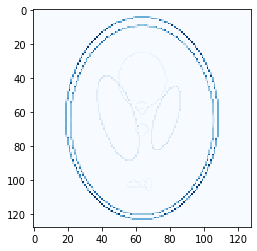

In [18]:
thresh = 0
lap = cv2.Laplacian(img,cv2.CV_64F,ksize=1)
lap_th = np.copy(lap)
lap_th[lap_th < thresh] = 0
# lap_th[lap_th != 0] = 1
plt.imshow(lap_th)
print(sparsity(lap_th))

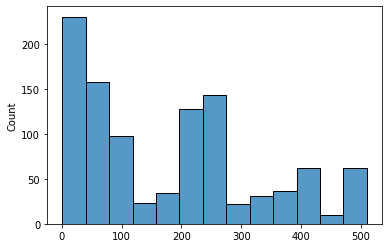

In [19]:
flat_lap = lap_th.reshape(N)
sns.histplot(flat_lap[np.nonzero(flat_lap)])

In [20]:
N = np.prod(img.shape)
p = N
print('shape: ', img.shape)
print('dim: ', p)
print('sparsity: ', sparsity(img))

shape:  (128, 128)
dim:  16384
sparsity:  0.42742919921875


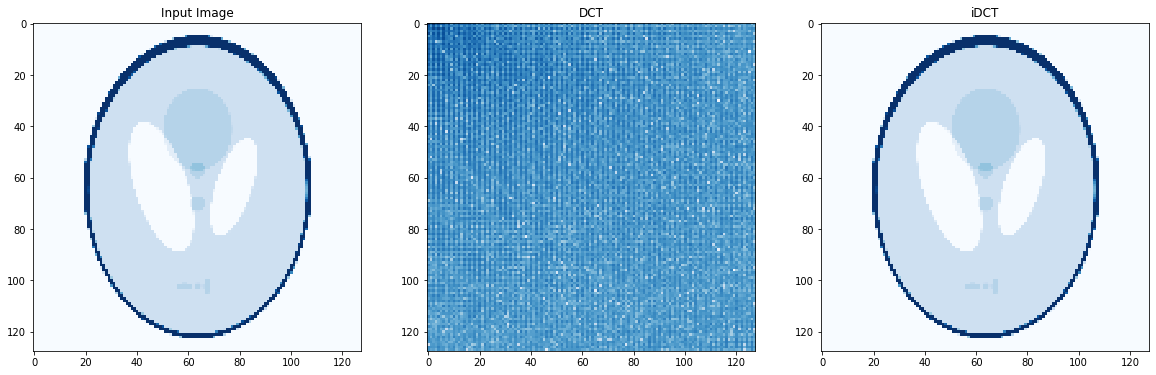

In [21]:
C = dctn(img, norm='ortho')
# Cshift = np.log(np.abs(np.fft.fftshift(C)))
invC = idctn(C, norm='ortho')
plt.figure(figsize=(20,20))
plt.subplot(131),plt.imshow(img)
plt.title('Input Image')
plt.subplot(132),plt.imshow(np.log(np.abs(C)))
plt.title('DCT')
plt.subplot(133), plt.imshow(invC)
plt.title('iDCT')
plt.show()

In [22]:
d = dct(np.eye(img.shape[0]), norm='ortho')
D = np.kron(d,d).T

In [23]:
X = np.sqrt(N) * D.copy()

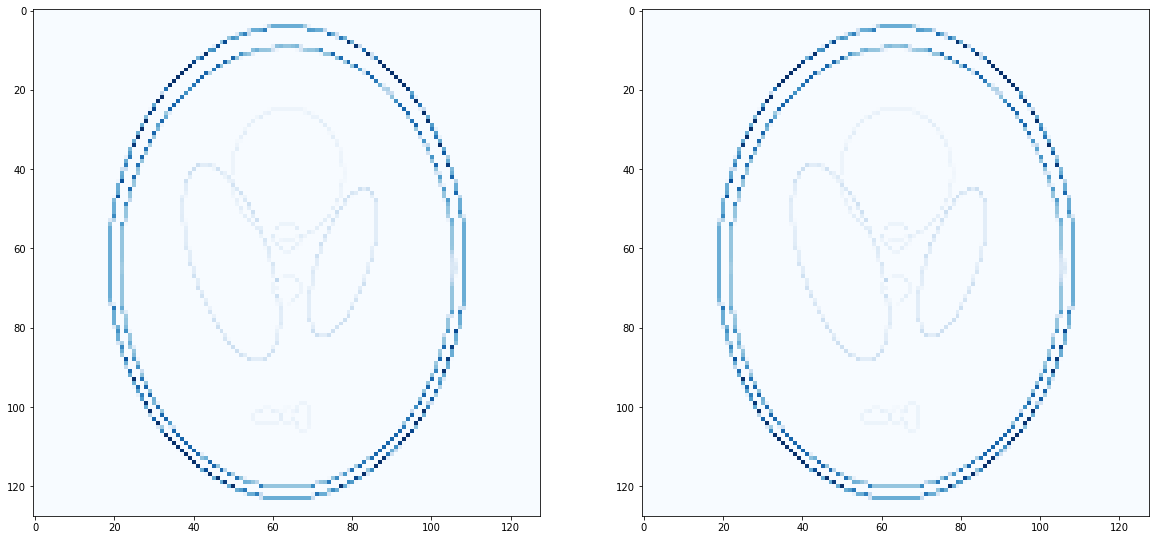

In [24]:
c_arr = np.zeros(img.shape)
c_arr[95:110, 50:75] = 1
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(lap_th)
plt.subplot(122)
plt.imshow(lap_th + c_arr)

In [25]:
N = np.prod(img.shape)
beta = lap_th.reshape(N)
c = c_arr.reshape(N)
c = c / np.sum(np.abs(c))
gamma = beta.T @ c

In [ ]:
import cvxpy as cp

In [ ]:
# N = np.prod(img.shape)

# w = cp.Variable((N), nonneg=True)
# alpha = 0.001
# sdp_const = X.T @ cp.diag(w) @ X - alpha * np.eye(N) >> 0
# constraints = [cp.sum(w) == 1]
# obj = cp.Minimize(cp.MatrixFrac(np.ones(N)/np.sqrt(N), X.T @ cp.diag(w) @ X))
# prob = cp.Problem(obj, constraints)

In [ ]:
# prob.solve(verbose = True)

In [ ]:
N = np.prod(img.shape)
w = cp.Variable((N), nonneg = True)
z = cp.Variable((N))
constraints = [X.T @ z == c, z - w <= 0, -z - w <= 0]
obj = cp.Minimize(cp.sum(w))
prob = cp.Problem(obj, constraints)

In [ ]:
prob.solve(verbose = True, abstol = 1e-5)

In [ ]:
w_opt = w.value / np.sum(w.value)

In [70]:
def c_optimize(X,c):
    N = X.shape[0]
    w = cp.Variable((N), nonneg = True)
    z = cp.Variable((N))
    constraints = [X.T @ z == c, z - w <= 0, -z - w <= 0]
    obj = cp.Minimize(cp.sum(w))
    prob = cp.Problem(obj, constraints)
    prob.solve(verbose = True, abstol = 1e-5)
    return(w.value / np.sum(w.value))
    

In [ ]:
#np.savetxt("w_opt.csv", w_opt, delimiter=",")

In [ ]:
w_opt[w_opt < 0]

## Read optimal weights

In [26]:
w_opt = np.loadtxt("w_opt.csv", delimiter=",")

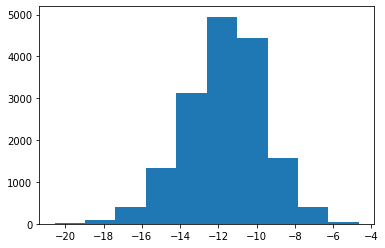

In [27]:
plt.hist(np.log(w_opt[w_opt > 0]))
plt.show()

In [15]:
sigma_opt = np.sqrt(c.T @ np.linalg.solve( X.T @ np.diag(w_opt) @ X, c))

In [16]:
sigma_unif = np.sqrt(c.T @ np.linalg.solve( X.T @ X / N, c))

In [17]:
(sigma_unif / sigma_opt)

4.974722710380467

In [ ]:
np.linalg.eigvalsh(X.T @ np.diag(w_opt) @ X)

In [ ]:
np.isclose(X.T @ X / N, np.eye(N))

In [28]:
from sklearn.linear_model import Lasso, LassoCV
from random import sample

In [37]:
def deb_lasso(x, y, c, u, lasso_tuning, beta_init):
    n = len(y)
    clf = Lasso(alpha=lasso_tuning, fit_intercept=False,
               warm_start=True, max_iter = 999999, copy_X = True,
                normalize = False)
    norms = np.sqrt(np.mean(x**2, axis = 0))
    clf.coef_ = beta_init  #Initialize at truth for faster computation
    clf.fit(x / norms, y)
    beta_hat = clf.coef_ / norms
    gamma_hat = c.T @ beta_hat + u.T @ x.T @ (y - x @ beta_hat) / n
    return [gamma_hat, beta_hat]

In [30]:
signal = X @ beta

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 5 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.0min finished


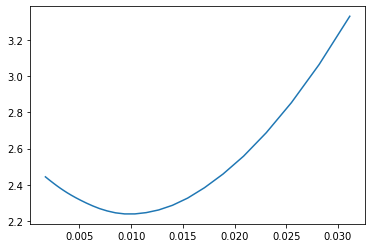

In [40]:
n = N // 2
lambda_theory = np.sqrt(np.log(N)/ n)
indices = np.random.choice(range(N), size=n)

y = signal[indices] + np.random.normal(size=n)

lasso_fit = LassoCV(cv = 10, fit_intercept=False, 
                    alphas=(np.exp(np.arange(-3, 0, 1e-1)))*lambda_theory,
                    n_jobs = -1, max_iter = 999999, verbose=True).fit(X[indices,:],y)

plt.plot(lasso_fit.alphas_, np.mean(lasso_fit.mse_path_, axis = 1))
plt.show()

In [43]:
beta_hat = lasso_fit.coef_
print(gamma)
print("Error: ", np.sum(np.abs(beta - beta_hat)))
print(np.sum(beta))
print(lambda_theory, lasso_fit.alpha_)
cv_lambda = lasso_fit.alpha_

0.10666666666666666
Error:  42.898707944147674
1035.0
0.03441769459380233 0.009379916019746007


# Uniform Sampling

In [31]:
n = N // 2
lambda_theory = np.sqrt(np.log(N)/ n)
u_unif = c
gamma = c.T @ beta
signal = X @ beta

In [57]:
gamma

0.10666666666666666

In [37]:
n = N // 2
n_reps = 5
gammas_unif = np.zeros(n_reps)
signal = X @ beta
beta_hat = np.zeros(N)

for i in range(n_reps):
    indices = np.random.choice(range(N), size=n)
    y = signal[indices] + np.random.normal(size=n)    
    gammas_unif[i], beta_hat = deb_lasso(X[indices,:], y, c, u_unif, lambda_theory, beta_hat.copy())
    
    print_progress(n_reps, i)
    print(gammas_unif[i] - gamma)

100 % done
-0.010557183864339681


In [38]:
gammas_unif - gamma

array([-0.00935031,  0.00636007, -0.00872627,  0.00176797, -0.01055718])

In [42]:
gamma

2.6000000000000005

In [67]:
np.savetxt(fname = 'unif_dist.csv', X = gammas_unif, delimiter = ',')

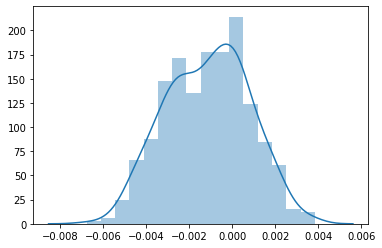

bias:  -0.00115171559733028
std:  0.0019342389201397066
0.000570544330734548


In [68]:
sns.distplot(gammas_unif - gamma)
plt.show()
print("bias: ", np.mean(gammas_unif) - gamma)
print("std: ", np.std(gammas_unif))
print((np.linalg.norm(c) / np.sqrt(n)))

In [ ]:
# np.savetxt("unif_dist.csv", gammas_unif, delimiter=",")

# Optimal Sampling

In [40]:
u_opt = np.linalg.solve(X.T @ np.diag(w_opt) @ X, c)

In [41]:
n_reps = 5
gammas_opt = np.zeros(n_reps)
beta_hat = np.zeros(N)
for i in range(n_reps):
    indices = np.random.choice(range(N), size=n, p=w_opt)
    y = signal[indices] + np.random.normal(size=n)

    gammas_opt[i], beta_hat = deb_lasso(X[indices,:], y, c, u_opt, lambda_theory, beta_hat.copy())
    
    print_progress(n_reps, i)
    print(gammas_opt[i] - gamma)

NameError: name 'cv_lambda' is not defined

In [46]:
# np.savetxt("opt_dist.csv", gammas_opt, delimiter=",")

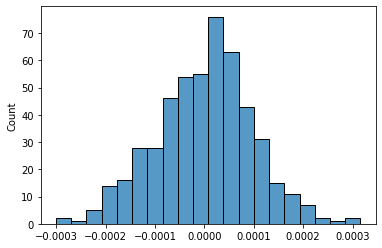

In [47]:
sns.histplot(gammas_opt - gamma)

In [97]:
sns.__version__

'0.9.0'

In [ ]:
sns.distplot((gammas_unif[:100] - gamma))
sns.distplot((gammas[:100] - gamma))

In [ ]:
plt.hist(np.sqrt(n)*(gammas - gamma))
plt.show()
print("bias: ", np.mean(gammas - gamma))
print("std: ", (np.std(np.sqrt(n)*(gammas - gamma))))

In [ ]:
plt.hist(np.sqrt(n)*(gammas_unif - gamma))
plt.show()
print("bias: ", np.mean(gammas_unif - gamma))
print("std: ", (np.std(np.sqrt(n)*(gammas_unif - gamma))))

In [ ]:
np.random.choice(range(10), 5)

In [ ]:
np.sum(np.isclose(w_opt, 0)) / N

In [ ]:
def grad(w, X, alpha, c):
    N = X.shape[0]
    Sigma = X.T @ np.diag(w) @ X
    u1 = c.T @ np.linalg.solve(Sigma, X.T)
    u2 = np.diag(X @ np.linalg.solve((Sigma - alpha * np.eye(N)), X.T))
    return -(u1 ** 2) - u2 / (N**2)

In [ ]:
def proj(y):
    N = len(y)
    u = sorted(y, reverse=True)
    v = np.cumsum(u)
    rho = np.where( (u + (1 - v)/(np.arange(N)+1)) >0)[0][-1]
    lam = (1 - v[rho])/(rho+1)
    return (y + lam) * ((y + lam)>0)

In [ ]:
n_iter = 1
step_size = 1e-3
alpha = 0.01
# w = np.ones(N) / N
for i in range(n_iter):
    g = grad(w, X, alpha, c)
    u = w - step_size * g / np.linalg.norm(g)
    print(np.max(np.abs(u)))
    w = proj(u)

In [ ]:
c.T @ np.linalg.solve(X.T @ np.diag(w) @ X, c)

In [ ]:
c.T @ np.linalg.solve(X.T @ X / N, c)

In [ ]:
np.linalg.eigvalsh(X.T @ np.diag(w) @ X)

In [ ]:
a = 0
def blah(b):
    b = b + 1
    
for i in range(10):
    blah(a)
    print(a)

# More simulations

In [114]:
from scipy.linalg import toeplitz
from sklearn.linear_model import Lasso, LassoCV
from random import sample
import cvxpy as cp
from scipy.stats import norm

In [74]:

N = 1000
p = 500
n = 200
ss = [5, 10]
mc_samples = 500



kappas = [0.1, 0.9]
# Sigma = toeplitz(kappa ** np.arange(p)).T
# u_unif = np.linalg.solve(Sigma, c)


lambda_theory = np.sqrt(np.log(p) / n)

In [99]:
np.random.seed(1)

beta_hat = np.zeros(p)
gamma_hats_unif = np.zeros([2, len(kappas), len(ss), mc_samples])
vars_unif = np.zeros([2, len(kappas), len(ss), mc_samples])
gammas = np.zeros([2, len(kappas), len(ss)])
    
for k in range(len(kappas)):
    Sigma = toeplitz(kappas[k] ** np.arange(p)).T
    X = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=N)
    for l in [0,1]:
        for j in range(len(ss)):
            beta = np.concatenate((np.arange(ss[j],0, -1), np.zeros(p - ss[j])), axis = 0) / ss[j]
            c = np.zeros(p)
            c[ss[j] + l - 1] = 1

            u_unif = np.linalg.solve(X.T @ X / N, c)

            signal = X @ beta
            gammas[l, k,j] = c.T @ beta
            
            for i in range(mc_samples):
                indices = np.random.choice(range(N), size=n)
                y = signal[indices] + np.random.normal(size=n)
                gamma_hats_unif[l, k, j, i], beta_hat = deb_lasso(X[indices,:], y, c, u_unif, lambda_theory, beta_hat.copy())
                vars_unif[l, k, j, i] = u_unif.T @ X[indices,:].T @ X[indices,:] @ u_unif / (n**2)
                print_progress(mc_samples, i)

99 % done


In [100]:
np.mean(gamma_hats_unif, axis = 3) - gammas

array([[[-0.00741991, -0.00499849],
        [ 0.00338051, -0.01087915]],

       [[-0.00609174, -0.01040796],
        [-0.00483919, -0.01336414]]])

In [101]:
np.std(gamma_hats_unif, axis = 3)

array([[[0.10092128, 0.10586833],
        [0.28455224, 0.31579955]],

       [[0.10239152, 0.10247408],
        [0.29687626, 0.3008129 ]]])

In [103]:
np.mean(np.sqrt(vars_unif), axis = 3)

array([[[0.09747906, 0.10026493],
        [0.30239911, 0.30653389]],

       [[0.10534118, 0.09685147],
        [0.30538942, 0.30126461]]])

In [95]:
np.random.seed(1)

beta_hat = np.zeros(p)
gamma_hats_opt = np.zeros([2, len(kappas), len(ss), mc_samples])
vars_opt = np.zeros([2, len(kappas), len(ss), mc_samples])
gammas = np.zeros([2, len(kappas), len(ss)])
    
for k in range(len(kappas)):
    Sigma_init = toeplitz(kappas[k] ** np.arange(p)).T
    X = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma_init, size=N)
    for l in [0,1]:
        for j in range(len(ss)):
            beta = np.concatenate((np.arange(ss[j],0, -1), np.zeros(p - ss[j])), axis = 0) / ss[j]
            c = np.zeros(p)
            c[ss[j] + l - 1] = 1

            signal = X @ beta
            gammas[l, k,j] = c.T @ beta
            w_opt = c_optimize(X, c)
            u_opt = np.linalg.solve(X.T @ np.diag(w_opt) @ X, c)

            for i in range(mc_samples):
                indices = np.random.choice(range(N), size=n, p = w_opt)
                y = signal[indices] + np.random.normal(size=n)
                gamma_hats_opt[l, k, j, i], beta_hat = deb_lasso(X[indices,:], y, c, u_opt, lambda_theory, beta_hat.copy())
                vars_opt[l, k, j, i] = u_opt.T @ X[indices,:].T @ X[indices,:] @ u_opt / (n**2)
                print_progress(mc_samples, i)

99 % done


In [104]:
np.mean(gamma_hats, axis = 3) - gammas

array([[[-0.0070414 , -0.01145838],
        [-0.00760301,  0.0053687 ]],

       [[-0.00617892, -0.00402471],
        [-0.00947508,  0.01922104]]])

In [105]:
1 - np.std(gamma_hats, axis = 3) / np.std(gamma_hats_unif, axis = 3)

array([[[0.2940931 , 0.29714243],
        [0.26387482, 0.36025669]],

       [[0.32671739, 0.30394531],
        [0.32258355, 0.3138248 ]]])

In [106]:
np.std(gamma_hats, axis = 3)

array([[[0.07124103, 0.07441036],
        [0.20946607, 0.20203065]],

       [[0.06893843, 0.07132756],
        [0.20110886, 0.20641035]]])

In [109]:
np.mean(np.sqrt(vars_opt), axis = 3)

array([[[0.06499012, 0.06712503],
        [0.20856639, 0.20622425]],

       [[0.06990412, 0.065541  ],
        [0.19831938, 0.20068078]]])

In [116]:
normal_cdf = norm().cdf

z_025 = normal_cdf(0.25)

In [117]:
z_025

0.5987063256829237

In [125]:
gamma_hats_unif + np.sqrt(vars_unif) * norm().interval(0.95)[0]

array([[[[ 0.11255274,  0.19189783, -0.12539677, ...,  0.31403056,
          -0.1168059 ,  0.06822752],
         [-0.09189414, -0.21573104, -0.05496396, ..., -0.12841808,
          -0.15969322,  0.066477  ]],

        [[-0.78671038, -0.56967056,  0.12401903, ..., -0.49258596,
          -0.14489966, -0.4287725 ],
         [-0.25041649, -0.70978226, -0.3106735 , ..., -0.61244229,
          -0.87701756, -0.51702236]]],


       [[[-0.27864002, -0.40923738, -0.26565186, ..., -0.12802517,
          -0.183045  , -0.24856227],
         [-0.40926533, -0.39168361, -0.10502705, ..., -0.20977873,
          -0.27682197, -0.19540451]],

        [[-0.60284184, -0.77659536, -0.24842755, ..., -0.48971923,
          -0.64960679, -0.24581322],
         [-0.26601976, -0.13329396, -0.1437852 , ..., -0.66918909,
          -0.31084828, -0.77755537]]]])

In [146]:
np.sum((gamma_hats_opt +
        np.sqrt(vars_opt) *
        norm().interval(0.95)[0]) > 0, axis = 3) / mc_samples +\
            np.sum((gamma_hats_opt[:,:,:,:] +
                np.sqrt(vars_opt)[:,:,:,:] *
                norm().interval(0.95)[1]) < 0, axis = 3) / mc_samples

array([[[0.806, 0.29 ],
        [0.156, 0.078]],

       [[0.048, 0.064],
        [0.042, 0.056]]])

In [147]:
np.sum((gamma_hats_unif +
        np.sqrt(vars_unif) *
        norm().interval(0.95)[0]) > 0, axis = 3) / mc_samples +\
            np.sum((gamma_hats_unif[:,:,:,:] +
                np.sqrt(vars_unif)[:,:,:,:] *
                norm().interval(0.95)[1]) < 0, axis = 3) / mc_samples

array([[[0.496, 0.152],
        [0.096, 0.064]],

       [[0.054, 0.058],
        [0.048, 0.046]]])

In [151]:
np.sum((gamma_hats_opt +
        np.sqrt(vars_opt) *
        norm().interval(0.95)[0]) < gammas, axis = 3) / mc_samples 

ValueError: operands could not be broadcast together with shapes (2,2,2,500) (2,2,2) 

In [224]:
gammas_array = np.array([gammas.T] * mc_samples).T

In [232]:
np.sum(((gamma_hats_opt +
        np.sqrt(vars_opt) *
        norm().interval(0.95)[0]) <= gammas_array) *\
       ((gamma_hats_opt +
        np.sqrt(vars_opt) *
        norm().interval(0.95)[1]) >= gammas_array),axis = 3) / mc_samples 

array([[[0.928, 0.926],
        [0.938, 0.944]],

       [[0.952, 0.936],
        [0.958, 0.944]]])

In [233]:
np.sum(((gamma_hats_unif +
        np.sqrt(vars_unif) *
        norm().interval(0.95)[0]) <= gammas_array) *\
       ((gamma_hats_unif +
        np.sqrt(vars_unif) *
        norm().interval(0.95)[1]) >= gammas_array),axis = 3) / mc_samples 

array([[[0.952, 0.936],
        [0.97 , 0.938]],

       [[0.946, 0.942],
        [0.952, 0.954]]])

In [238]:
np.sqrt(n) * np.std(gamma_hats_opt, axis = 3)

array([[[1.00750026, 1.05232134],
        [2.96229758, 2.85714482]],

       [[0.97493665, 1.00872406],
        [2.84410876, 2.91908322]]])

In [237]:
np.sqrt(n) * np.std(gamma_hats_unif, axis = 3)

array([[[1.4272424 , 1.49720426],
        [4.02417638, 4.46608003]],

       [[1.4480348 , 1.4492023 ],
        [4.19846428, 4.25413685]]])